# Identifying Fraud from Enron Data
### - Marty VanHoof

## Introduction

Founded in 1985, Enron was one of the world's major electricity, natural gas, communications and pulp and paper companies.  Enron was named "America's Most Innovative Company" for six consecutive years by *Fortune* magazine.  Much of this apparent success, though, was due to systematic and elaborate accounting fraud and corruption.  By the use of accounting loopholes, special purpose entities, and poor financial reporting, they were able to hide billions of dollars in debt from failed deals and projects.  By 2002, it had collapsed into bankruptcy, and many executives at Enron would later be indicted and some of them sent to prison.  In the resulting investigation, a large amount of typically confidential information entered into the public record.  This included a large database of emails known as the *Enron Corpus*, and also detailed financial data for top executives.  

The purpose of this project is to try to probe this financial and email data using machine learning techniques in order to attempt to identify persons of interest (POI) in the Enron scandal.  POIs are individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.  This report details the following process:
- [data exploration and outlier removal](#exploration)
- [initial classifier estimation](#initial)
- [feature engineering and feature selection](#features)

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a id='exploration'></a>
## Data Exploration / Outlier Removal

We begin by doing some exploratory data analysis (EDA) in order to get a better understanding of the dataset and remove a few outliers.  The Enron email and financial data has been preprocessed and combined into a Python dictionary, where each key-value pair in the dictionary corresponds to one person.  The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. 

In order to make our EDA easier, we will use the Python library Pandas to first transform our Python dictionary into a Pandas dataframe.

In [2]:
# load the dictionary containing the dataset
with open('enron_dataset.pkl', 'rb') as data_file:
    data_dict = pickle.load(data_file)
    
# create a dataframe from data_dict and set the index column to employees
df = pd.DataFrame.from_dict(data_dict, orient='index')

# coerce numeric values into floats and convert NaN values to 0
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
df.fillna(0, inplace=True)

Below are the first 5 rows of our dataset.  The row observations correspond to Enron employees and the columns are the features (the email and financial information for the employee).  There were many missing values in the original financial dataset and these values were encoded in the Python dictionary as 'NaN'.  These NaN values are transformed to 0 in the dataframe.

In [3]:
df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,0.0,4175000.0,0.0,-126027.0,-3081055.0,1729541.0,...,47.0,1729541.0,2195.0,152.0,65.0,False,304805.0,1407.0,126027.0,0.0
BADUM JAMES P,0.0,0.0,178980.0,182466.0,0.0,0.0,0.0,0.0,0.0,257817.0,...,0.0,257817.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,0.0,0.0,0.0,-560222.0,-5104.0,5243487.0,...,39.0,4046157.0,29.0,864523.0,0.0,False,0.0,465.0,1757552.0,0.0
BAXTER JOHN C,267102.0,0.0,1295738.0,5634343.0,0.0,1200000.0,0.0,0.0,-1386055.0,10623258.0,...,0.0,6680544.0,0.0,2660303.0,0.0,False,1586055.0,0.0,3942714.0,0.0
BAY FRANKLIN R,239671.0,0.0,260455.0,827696.0,0.0,400000.0,0.0,-82782.0,-201641.0,63014.0,...,0.0,0.0,0.0,69.0,0.0,False,0.0,0.0,145796.0,0.0


### Some Dataset Characteristics

In [4]:
print('number of data points: ', df.shape[0])
print('number of features: ', df.shape[1])
print('number of POIs: ', df.query('poi == True').shape[0])
print('number of non POIs: ', df.query('poi == False').shape[0])

number of data points:  146
number of features:  21
number of POIs:  18
number of non POIs:  128


Below are the features with missing values (zeros) and the number of missing values for each feature.  We exclude the email addresses since they don't provide useful information and were all converted to zeros in the dataframe.

In [5]:
# print the number of missing values (zeros) for each feature except 'email_address'
zero_counts = (~df.astype(bool)).sum(axis=0)
zero_counts.drop('email_address')

salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
loan_advances                142
bonus                         64
restricted_stock_deferred    128
deferred_income               97
total_stock_value             20
expenses                      51
from_poi_to_this_person       72
exercised_stock_options       44
from_messages                 60
other                         53
from_this_person_to_poi       80
poi                          128
long_term_incentive           80
shared_receipt_with_poi       60
restricted_stock              36
director_fees                129
dtype: int64

### Outliers

Now we will remove a few outliers from the dataset.  Since the dataset is quite small, we should be conservative in removing outliers.  Also, due to the nature of the financial data, outliers such as very larges salaries, bonuses, etc, can be a signal that a particular individual is a POI, so we won't remove any of these (except for the 'TOTAL' row mentioned next). 

The Enron financial data comes from a PDF file called [enron61702insiderpay.pdf](https://github.com/marty-vanhoof/Identifying_Fraud_from_Enron_Data/blob/master/enron61702insiderpay.pdf), which contains a row of totals for each financial feature, and this row was read into the Python dictionary (and thus in the dataframe) as an individual observation where it really doesn't belong:

In [6]:
# show the row of totals
df[df.index.values == 'TOTAL']

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
TOTAL,26704229.0,0.0,32083396.0,309886585.0,83925000.0,97343619.0,0.0,-7576788.0,-27992891.0,434509511.0,...,0.0,311764000.0,0.0,42667589.0,0.0,False,48521928.0,0.0,130322299.0,1398517.0


We can get a good view of this outlier from a scatterplot of salaries and bonuses of Enron employees.  This outlier should really be removed because it will throw off our predictions when we try to fit models to the data.

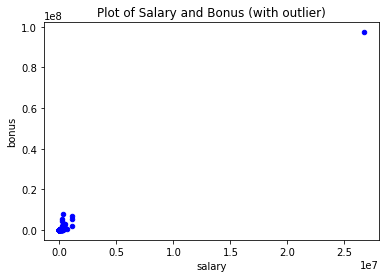

In [7]:
df.plot.scatter(x='salary', y='bonus', color='blue',
                title='Plot of Salary and Bonus (with outlier)');

We should also check for observations that contain all zeros, and we can see that this person 'LOCKHART EUGENE E' doesn't have any records.  Finally, if we examine all the names in the dataframe there is one that doesn't seem to belong:  'THE TRAVEL AGENCY IN THE PARK'.  This is probably not a person, so we will remove this observation along with 'TOTAL' and 'LOCKHART EUGENE E'.  Once we convert the dataframe back into a Python dictionary, it will then be easy to remove these observations.

In [8]:
display(df.loc[(df == 0).all(axis=1)])
df[df.index.values == 'THE TRAVEL AGENCY IN THE PARK']

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
LOCKHART EUGENE E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0


,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
THE TRAVEL AGENCY IN THE PARK,0.0,0.0,0.0,362096.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,362096.0,0.0,False,0.0,0.0,0.0,0.0


<a id='initial'></a>
## Initial Classifier Estimation

We will start by experimenting with a few different classifiers without worrying about parameter-tuning at this point.  Using the **`test_classifier()`** function in the [tester.py](tester.py) file, we can get an initial idea of the performance of each classifier before we get into tuning the parameters.  We will start by using all the features in the dataset (except email address).  The metrics that we want to optimize are the precision, recall, and the F1 score.

Consider the collection of all people in the Enron dataset who the model predicts to be a POI; then the **precision** is the proportion of those people who are actually POIs.  More precisely, if $TP$ is the number of true positives and $FP$ is the number of false positives, then

$$
\textrm{precision} = \frac{TP}{TP + FP}
$$

Now consider the collection of all people in the Enron dataset who are actually POIs; then the **recall** is the proportion of those individuals who are predicted by the model to be POIs.  If $FN$ is the number of false negatives, then

$$
\textrm{recall} = \frac{TP}{TP + FN}
$$

The **F1 score** is the harmonic mean of precision and recall and can also be interpreted as a weighted average of precision and recall

$$
\textrm{F1 score} = \frac{2}{\frac{1}{\textrm{precision}} + \frac{1}{\textrm{recall}}} = \frac{2 \cdot \textrm{precision} \cdot \textrm{recall}}{\textrm{precision} + \textrm{recall}}
$$

Note that our dataset is imbalanced, since there are 18 POI versus 128 non POI.  This means that the accuracy score (number of accurate predictions divided by the total number of data points) is not a good metric to use.

At this point we should also standardize the data since the financial and email data are measured in different units and on different scales.  We will standardize the data so that it has mean 0 and standard deviation 1. 

In [54]:
# Note:  The scripts tester.py and feature_format.py are from Udacity's
# Intro to Machine Learning Course
from tester import test_classifier
from feature_format import featureFormat, targetFeatureSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# convert the dataframe back into a dictionary
data_dict = df.to_dict('index')

# remove outliers
data_dict.pop('TOTAL', 0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0)
data_dict.pop('LOCKHART EUGENE E', 0)

# get a list of all the features and remove 'email_address'
features_list = list(df.columns.values)
features_list.remove('email_address')

# move 'poi' to the beginning of the list for use by the function
# targetFeatureSplit() in feature_format.py
features_list.pop(features_list.index('poi'))
features_list.insert(0, 'poi')

def clf_report(classifier, f_list):
    ''' A quick and dirty function that fits a specific classifier then uses 'test_classifier()'
        to evaluate the model's performance '''
    
    # Extract features and labels from dataset
    data = featureFormat(my_dataset, f_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    
    # Apply feature scaling
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)

    # Split features and labels into training and testing sets
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
    
    clf = classifier()
    clf.fit(features_train, labels_train)
    test_classifier(clf, my_dataset, f_list)